## Optimization of Attainable Control Set for Octocopter by rotor inclination
*Authors: Uwe Klingauf and Tilman Strampe, Institute of Flight Systems and Automatic Control, TU Darmstadt, 28.02.2024*

This example shows the optimization of the control radius in the roll-pitch plane of the ACS for an Octocopter. By changing the rotor inclination $\mu$ the set is optimized. 
Additionally, the weights of a weighted pseudo-inverse are optimized by the rotor inclination.

In [1]:
import numpy as np
import pypoman as pm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds
import octo_eff_matrix as motor_matrix
from plotACS import plotACS

In [2]:
# define parameters
n_fault = 1  # faulty rotor (1...8)
T_max = 1.0  # maximum rotor thrust in [kgf]
mass = 3.8   # total mass in [kg]
g = 9.80665  # gravitational acceleration [m/s^2]
l1 = 0.45    # odd motor arm length in [m]
l2 = 0.35    # even motor arm length in [m]
mu = 0.0     # rotor inclination angle in [deg]
ct = 1.0     # rotor thrust constant
cm = 0.025   # rotor torque constant

# compute nominal actuator effectiveness matrix B_nom
param = motor_matrix.parameters(mu, ct, cm, l1, l2)
B_nom = motor_matrix.motor_matrix(param)
B_nom[0:3,:] = B_nom[0:3,:]*g  # moments in [Nm], thrust in [kgf]
B_nom[5,:] = -B_nom[5,:]  # thrust vector pointing up
B_nom = np.delete(B_nom, [3, 4], 0)  # acceleration X and side force Y are neglected
print(B_nom.round(4))

# compute actuator effectiveness matrix for faulty rotor n_fault
B_fault = np.copy(B_nom)
B_fault[:,n_fault-1] = 0.0
#print(B_fault)

# compute control allocation matrix via pseudo-inverse
B_f_plus = np.transpose(B_fault) @ np.linalg.inv((B_fault @ np.transpose(B_fault)))  # calculate pseudo-inverse
#print(B_f_plus)

[[ 0.     -2.427  -4.413  -2.427  -0.      2.427   4.413   2.427 ]
 [ 4.413   2.427   0.     -2.427  -4.413  -2.427   0.      2.427 ]
 [-0.2452  0.2452 -0.2452  0.2452 -0.2452  0.2452 -0.2452  0.2452]
 [ 1.      1.      1.      1.      1.      1.      1.      1.    ]]


In [3]:
# set inequality constraints for attainable control set (ACS)
A = np.kron(np.eye(8),np.array([[1.0],[-1.0]]))
b = np.array([T_max, 0.0, T_max, 0.0, T_max, 0.0, T_max, 0.0, T_max, 0.0, T_max, 0.0, T_max, 0.0, T_max, 0.0])
ineq = (A, b)
b_fault = np.copy(b)
b_fault[2*(n_fault-1)] = 0.0  # set faulty rotor thrust to zero
ineq_fault = (A, b_fault)     # inequality constraints for polytope A * x <= b
ineq_f_pseudo = (A @ B_f_plus, b_fault)

In [4]:
# compute minimum radius of roll / pitch control polytope
def control_radius(mu):
    param = motor_matrix.parameters(mu, ct, cm, l1, l2)
    B = motor_matrix.motor_matrix(param)
    B[0:3,:] = B[0:3,:]*g  # moments in [Nm], thrust in [kgf]
    B[5,:] = -B[5,:]  # thrust vector pointing up
    B = np.delete(B, [3, 4], 0)
    proj = (B[[0, 1],:], np.zeros(2))  # 2D projection of polytope y = E * x + f, select roll and pitch axis
    eq = (B[[2, 3],:], np.array([0, mass]))  # equality constraints C * x = d, yaw moment = zero, thrust = mg
    vertices_fault = np.array(pm.project_polytope(proj, ineq_fault, eq, method='bretl'))  # determine closest distance of roll/pitch polytope to origin
    A_res, b_res = pm.compute_polytope_halfspaces(vertices_fault) # compute half space representation from vertices
    for i in range(len(b_res)):  # transform into hesse normal form
        b_res[i] = b_res[i] / np.linalg.norm(A_res[i,:])
    radius = min(b_res)  # find minimum distance
    return -radius  # multiply objective function by -1 to change max problem to min problem

### Calculation of ACS for inclination $\mu=0$
The following plots show the ACS for inclination $\mu=0$ in two dimensions. In blue the ACS of an octocopter without any failure is shown, in red the ACS for a failure of rotor 1. The yellow area is the achievable ACS using a pseudo-inverse for Control Allocation. The radius in the roll-pitch plane is shown in black.

For inclination of 0.0° the maximum radius is  3.74 Nm


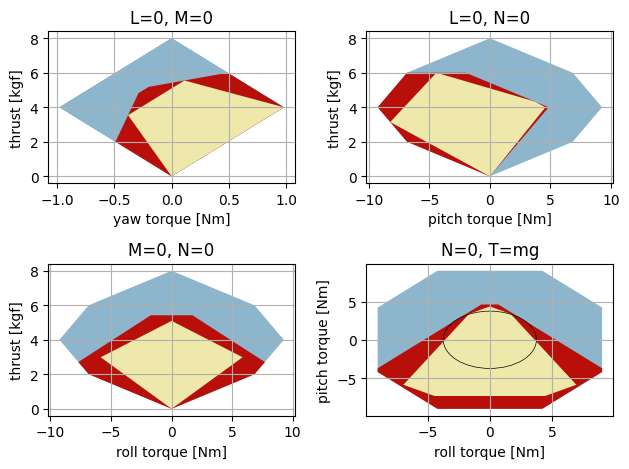

In [6]:
radius = -control_radius(mu)
print("For inclination of %2.1f° the maximum radius is %5.2f Nm" % (mu, radius))
fig_mu0 = plotACS(B_nom, ineq, ineq_fault, ineq_f_pseudo, mass, radius)
fig_mu0.savefig("acs_mu0.png") # save as png

### Optimization of ACS using inclination
Next, the radius in the roll-pitch plane is optimized by using the rotor inclination. 

For inclination of 6.8° the maximum radius is  4.13 Nm


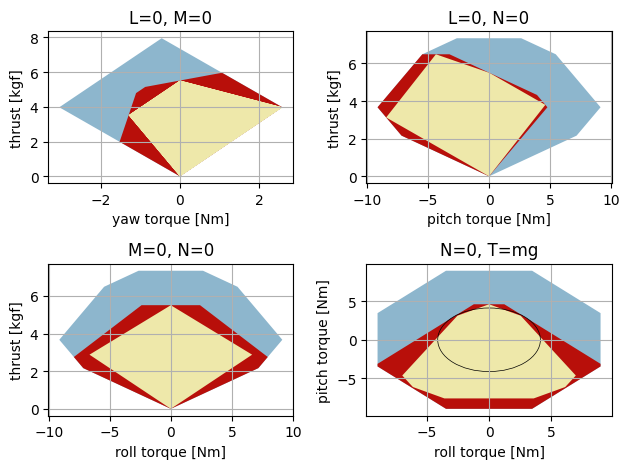

In [7]:
# Optimize the inclination mu
mu0 = 0.0
bnds = Bounds(lb=-10.0, ub=10.0)  # maximum 10 deg inclination
res = minimize(control_radius, mu0, method='Nelder-Mead', bounds=bnds, tol=1e-6)
mu_opt = res.x

radius_opt = -control_radius(mu_opt)
print("For inclination of %2.1f° the maximum radius is %5.2f Nm" % (mu_opt, radius_opt))
B_nom = motor_matrix.motor_matrix(motor_matrix.parameters(mu_opt, ct, cm, l1, l2))
B_nom[0:3,:] = B_nom[0:3,:]*g  # moments in [Nm], thrust in [kgf]
B_nom[5,:] = -B_nom[5,:]  # thrust vector pointing up
B_nom = np.delete(B_nom, [3, 4], 0)  # acceleration X and side force Y are neglected
B_fault = np.copy(B_nom)
B_fault[:,n_fault-1] = 0.0
B_f_plus = np.transpose(B_fault) @ np.linalg.inv((B_fault @ np.transpose(B_fault)))  # calculate pseudo-inverse
ineq_f_pseudo = (A @ B_f_plus, b_fault)
fig_opt = plotACS(B_nom, ineq, ineq_fault, ineq_f_pseudo, mass, radius_opt)

### Optimization of weighted pseudo-inverse for Control allocation
The radius in the roll-pitch plane is now used to optimize the weights of a weighted pseudo-inverse. For the input matrix $B$ with
$$
\nu = B\cdot u
$$
the weighted pseudo-inverse is given by

$$ B^{+}=W^{-1}B^{T}(B W^{-1} B^{T})^{-1} $$

where $W$ is a diagonal weigh matrix.rix.rix.

In [8]:
def control_radius_w(w):
    # compute weighted pseudo-inverse
    we = np.insert(w, n_fault-1, 1)  # insert weight for faulty rotor set to 1
    W = np.diag(we)                  # weighting matrix
    WI = np.linalg.inv(W)            # inverse weighting matrix
    B_f_plus = WI @ np.transpose(B_fault) @ np.linalg.inv((B_fault @ WI @ np.transpose(B_fault)))
    
    # 2D projection of polytope y = E * x + f, select roll and pitch axis
    proj = (np.array([[1,0,0,0],[0,1,0,0]]), np.zeros(2))
    ineq_f_pseudo = (A @ B_f_plus, b_fault)                      # inequality constraints for polytope A * x <= b
    eq = (np.array([[0,0,1,0],[0,0,0,1]]), np.array([0, mass]))  # equality constraint for yaw = 0 and thrust = mass
    vertices_f_pseudo = np.array(pm.project_polytope(proj, ineq_f_pseudo, eq, method='bretl'))
    
    # compute half space representation from vertices
    A_res, b_res = pm.compute_polytope_halfspaces(vertices_f_pseudo)
    # transform into hesse normal form
    for i in range(len(b_res)):  
        b_res[i] = b_res[i] / np.linalg.norm(A_res[i,:])
    radius = min(b_res)  # find minimum distance
    return -radius       # multiply objective function by -1 to change max problem to min problem

Optimum weighting factors:  [1.   1.23 1.22 1.75 0.47 0.38 0.94 1.03]
The attainable roll-pitch radius with CA is 3.96 Nm


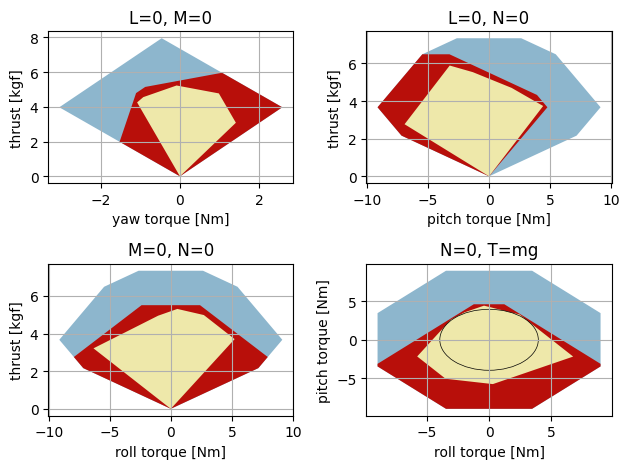

In [9]:
# find optimum weighting matrix for weighted pseudo-inverse
w0 = np.ones(7)
bnds = ((0.1, 2),)*7  # set lower and upper bound for weights
res = minimize(control_radius_w, w0, method='Nelder-Mead', bounds=bnds, tol=1e-6)
radius_opt = -control_radius_w(res.x)
with np.printoptions(precision=2, suppress=True):
    print("Optimum weighting factors: ", np.insert(res.x, n_fault-1, 1))
print("The attainable roll-pitch radius with CA is %4.2f Nm" % (radius_opt))

# compute resulting weighted pseudo-inverse
we = np.insert(res.x, n_fault-1, 1)  # insert weight for faulty rotor set to 1
W = np.diag(we)  # weighting matrix
WI = np.linalg.inv(W)  # inverse weighting matrix
B_f_plus = WI @ np.transpose(B_fault) @ np.linalg.inv((B_fault @ WI @ np.transpose(B_fault)))  # calculate pseudo-inverse
ineq_f_pseudo = (A @ B_f_plus, b_fault)
fig_opt = plotACS(B_nom, ineq, ineq_fault, ineq_f_pseudo, mass, radius_opt)
fig_opt.savefig("acs_opt.png") # save as png

### Calculation of rotor loads for hovering
Using the weighted pseudo-inverse, the rotor loads are calculated for the hovering condition, i.e. all torques are zero and total thrust is equal to the copter's weight. 

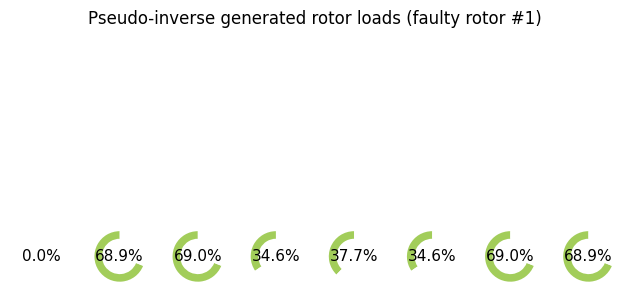

In [10]:
# calculate the rotor loads in hovering state
v_cmd = np.array([0,0,0,mass])  # steady state L, M, N equal zero, thrust = weight
B_fault = np.copy(B_nom)
B_fault[:,n_fault-1] = 0.0
B_f_plus = np.transpose(B_fault) @ np.linalg.inv((B_fault @ np.transpose(B_fault)))  # calculate pseudo-inverse
u = B_f_plus @ np.transpose(v_cmd)
v = B_fault @ u
# print(u)
# print(v)

fig, ax = plt.subplots(1,8)
fig.suptitle("Pseudo-inverse generated rotor loads (faulty rotor #{0:d})".format(n_fault))

# plot donut charts
for i in range(8):
    value = u[i]/T_max
    if(value<0.0):
        value = 0.0
    if value > 0.9:
        colors = ['#EE2C2C', '#FFFFFF']
    elif value > 0.8:
        colors = ['#EEC900', '#FFFFFF']
    else:
        colors = ['#A2CD5A', '#FFFFFF']
    if value > 1:
        ax[i].pie([1,0], wedgeprops={'width':0.3}, startangle=90, colors=colors)
    else:
        ax[i].pie([value,1-value], wedgeprops={'width':0.3}, startangle=90, colors=colors)
    ax[i].text(0, 0, "{0:.1f}%".format(value*100), ha='center', va='center', fontsize=11)

fig.tight_layout()
plt.show()
fig.savefig("loads.png")